In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

In [3]:
!ls

 base_info_produtos.csv  'Desafio Ciência de Dados - Matching.pdf'
 base_info_produtos.zip   main.ipynb


In [280]:
df = pd.read_csv('./base_info_produtos.csv',sep='\t')
display(df.head())

,nome,tipo,marca,categoria,cor,modelo
0,Samsung UN40C6900 LED Plana 40 Polegadas,TV,Samsung,Eletrônicos,None,None
1,Sapateira Limeira Alta 30 Pares Tabaco - Polit...,Armario,Politorno,Casa e Decoração,None,None
2,Faqueiro Tramontina Inox Laguna 66906760 20,Faqueiro,Tramontina,Casa e Decoração,Inox,None
3,Cartucho de tinta HP 72 C9371A 130 Mls Ciano,Cartucho,HP,None,None,None
4,Bolsa Pure Evo Medium Grip branco e preto - Puma,Bolsa,Puma,Moda e Acessórios,None,None


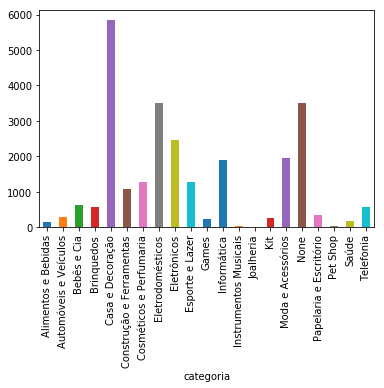

In [281]:
df.groupby(['categoria']).size().plot(kind='bar')

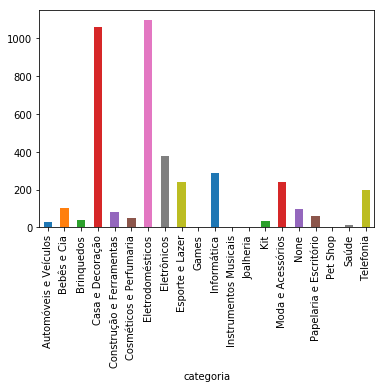

In [282]:
df[(df.cor != 'None')].groupby(['categoria']).size().plot(kind='bar')

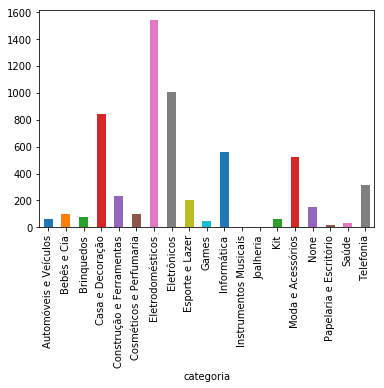

In [283]:
df[(df.modelo != 'None')].groupby(['categoria']).size().plot(kind='bar')

In [288]:
df[(df.tipo == 'Celular') & (df.cor != 'None') & (df.modelo != 'None')].head()

,nome,tipo,marca,categoria,cor,modelo
1043,Venko Talento GSM Desbloqueado,Celular,Venko,Telefonia,Roxo,cha31
1069,Celular ZTE R620 Vermelho e Preto GSM,Celular,ZTE,Telefonia,Vermelho,r620
1211,Samsung GT-E2120 GSM Desbloqueado,Celular,Samsung,Telefonia,Preto,e2121
1432,Celular Desbloqueado TIM ZTE R221 Rosa Dual Ch...,Celular,ZTE,Telefonia,Rosa,rde30
1637,"Celular Samsung Ch@t 335 Qwerty, Wi-Fi, Redes ...",Celular,Samsung,Telefonia,Branco,lb12q


# Text cleaning / formating / feature engineering

In [375]:
cs = ' '
df['text'] = df['nome'].map(str) + cs \
            + df['tipo'].map(str) + cs \
            + df['marca'].map(str) + cs \
            + df['categoria'].map(str) + cs \
            + df['cor'].map(str) + cs \
            + df['modelo'].map(str)
            
df['text'] = df['text'].apply( lambda x: x.replace('None',''))
df['text'] = df['text'].apply(lambda x: x.lower())

texts = df['text'].values

In [376]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [377]:
texts = df['text'].values

## Matrix of similarities

In [463]:
vect = TfidfVectorizer(analyzer='word',lowercase=True,use_idf=True)
#vect = TfidfVectorizer(analyzer='word',lowercase=True,ngram_range=(1,3), use_idf=False)
#vect = TfidfVectorizer(analyzer='char',lowercase=True,ngram_range=(3,5), use_idf=False)

In [464]:
v = vect.fit_transform(texts[:1000]).toarray()

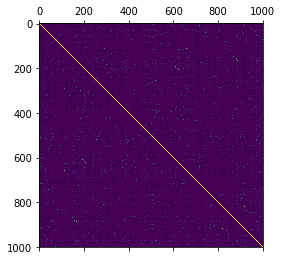

In [465]:
cosine_sim = 1-cosine_distances(v)
plt.matshow(pd.DataFrame(cosine_sim))

In [466]:
### Print most similar text products 
for i in range(0, len(cosine_sim), +1):
    for j in range(i-1, 0, -1):
        if cosine_sim[i][j] > 1:#0.7:
            print(i,j, cosine_sim[i][j])
            print(text[i],'=>', text[j])
            
def cosine(idx_a, idx_b):
    return cosine_sim[idx_a][idx_b]

# probability of two products be the same

In [467]:
# cosine distance, categoria, marca, tipo, cor e modelo

In [468]:
idx_a = 220
idx_b = 191

In [469]:
cosine(idx_a, idx_b)

0.5379446499495619

In [471]:
def prob_duplicate(idx_a, idx_b):
    c = cosine(idx_a, idx_b)
    tipo = df.loc[idx_a]['tipo'] == df.loc[idx_b]['tipo']
    marca = df.loc[idx_a]['marca'] == df.loc[idx_b]['marca']
    categoria = df.loc[idx_a]['categoria'] == df.loc[idx_b]['categoria']
    cor = df.loc[idx_a]['cor'] == df.loc[idx_b]['cor']
    modelo = df.loc[idx_a]['modelo'] == df.loc[idx_b]['modelo']
    print(c, tipo, marca, categoria, cor, modelo)

In [569]:
print(df.loc[idx_a]['nome'])
print(df.loc[idx_b]['nome'])

cartucho de toner hp magenta - cc533a
cartucho de toner laserjet 53x q7553xb preto hp


In [472]:
prob_duplicate(idx_a, idx_b)

0.5379446499495619 True True True True False


# Find product

In [570]:
# query
query = ['sony playstation 3 slim 320']

def find_product(query):
    # transform
    query = vect.transform(query).toarray()
    # get cosine matrix database
    r = 1-cosine_distances(v, query)
    # get idx
    print(max(r))
    if max(r) > 0.0:    
        idx = np.where(r >= max(r))[0]
        return df.loc[idx]
    else: 
        return None
    
find_product(query)

[0.77511458]


,nome,tipo,marca,categoria,cor,modelo,text
773,sony playstation 3 slim 320 gb,Game,Sony,Games,Preto,sh70x,sony playstation 3 slim 320 gb game sony games...


# Search engine, show most relevants

In [567]:
# query
query = ['notebook sony 4 GB']

def find_product(query):
    # transform
    query = vect.transform(query).toarray()
    # get cosine matrix database
    r = 1-cosine_distances(v, query)
    # get idx
    
    if max(r) > 0.0:    
        arr_idx = np.where(r > 0.0)[0]
        
        f = pd.DataFrame(columns=['nome','tipo','marca','categoria','cor','modelo','rank'])
        
        for idx in arr_idx:
            a = df.loc[idx][['nome','tipo','marca','categoria','cor','modelo']].values
            a = np.append(a, r[idx])
            a = a.reshape(1, -1)
            f = f.append(pd.DataFrame(a, columns=['nome','tipo','marca','categoria','cor','modelo','rank']))
        return f.sort_values(['rank'], ascending=False)
    else: 
        return None
    
find_product(query)[:5]

,nome,tipo,marca,categoria,cor,modelo,rank
0,sony playstation 3 slim 320 gb,Game,Sony,Games,Preto,sh70x,0.52124
0,bateria p/ câmera digital sony np-fc10 - bestb...,Câmera Digital,Sony,Eletrônicos,None,None,0.343931
0,computador all in one touchscreen sony vaio vp...,Computador,Sony,Eletrônicos,Preto,dc49x,0.308897
0,sony bravia kdl-32cx525 lcd plana 32 polegadas,TV,Sony,Eletrônicos,None,kdl-32cx525,0.299117
0,câmera digital sony cyber-shot dsc-j10 16.1 me...,Câmera Digital,Sony,Eletrônicos,None,dsc-j10,0.256202
